# Generating Tabular Data via XGBoost Models with Flow-Matching

This notebook is a self-contained example showing how to train the novel Forest-Flow method to generate tabular data. The idea behind Forest-Flow is to learn Flow-Matching's vector field with XGBoost models instead of neural networks. The motivation is that it is known that Forests work currently better than neural networks on Tabular data tasks. This idea comes with some difficulties, for instance how to approximate Flow Matching's loss, and this notebook shows how to do it on a minimal example. The method, its training procedure and the experiments are described in [(Jolicoeur-Martineau et al. 2023)](https://arxiv.org/abs/2309.09968). The full code can be found [here](https://github.com/SamsungSAILMontreal/ForestDiffusion). 

# Imports

In [2]:
import copy
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
import xgboost as xgb
from joblib import Parallel, delayed
from sklearn.datasets import load_iris, make_moons
from sklearn.preprocessing import MinMaxScaler

from torchcfm.conditional_flow_matching import ConditionalFlowMatcher
import pandas as pd

In [3]:
# set seed
seed = 1980
np.random.seed(seed)


import numpy as np

def pad_t_like_x(t, x):
    """Function to reshape the time vector t by the number of dimensions of x.
    
    Parameters
    ----------
    x : ndarray, shape (bs, *dim)
        represents the source minibatch
    t : ndarray, shape (bs)
    
    Returns
    -------
    t : ndarray, shape (bs, number of x dimensions)
    """
    if isinstance(t, (float, int)):
        return t
    return np.reshape(t, (-1, *([1] * (x.ndim - 1))))

class ConditionalFlowMatcher:
    """Base class for conditional flow matching methods using numpy."""

    def __init__(self, sigma=0.0):
        """Initialize the ConditionalFlowMatcher class with hyper-parameter sigma."""
        self.sigma = sigma

    def compute_mu_t(self, x0, x1, t):
        """Compute the mean of the probability path N(t * x1 + (1 - t) * x0, sigma)."""
        t = pad_t_like_x(t, x0)
        return t * x1 + (1 - t) * x0

    def compute_sigma_t(self, t):
        """Compute the standard deviation of the probability path N(t * x1 + (1 - t) * x0, sigma)."""
        del t  # Unused variable t in the context of this function
        return self.sigma

    def sample_xt(self, x0, x1, t, epsilon):
        """Draw a sample from the probability path N(t * x1 + (1 - t) * x0, sigma)."""
        mu_t = self.compute_mu_t(x0, x1, t)
        sigma_t = self.compute_sigma_t(t)
        sigma_t = pad_t_like_x(sigma_t, x0)
        return mu_t + epsilon * sigma_t

    def compute_conditional_flow(self, x0, x1, t, xt):
        """Compute the conditional vector field ut(x1|x0) = x1 - x0."""
        del t, xt  # Unused variables
        return x1 - x0

    def sample_noise_like(self, x):
        """Sample noise from a normal distribution N(0, 1) with the same shape as x."""
        return np.random.randn(*x.shape)

    def sample_location_and_conditional_flow(self, x0, x1, t=None, return_noise=False):
        """Compute the sample xt and the conditional vector field ut."""
        if t is None:
            t = np.random.rand(x0.shape[0])
        assert len(t) == x0.shape[0], "t must have the same batch size dimension as x0"
        
        eps = self.sample_noise_like(x0)
        xt = self.sample_xt(x0, x1, t, eps)
        ut = self.compute_conditional_flow(x0, x1, t, xt)
        if return_noise:
            return t, xt, ut, eps
        else:
            return t, xt, ut

    def compute_lambda(self, t):
        """Compute the lambda function."""
        sigma_t = self.compute_sigma_t(t)
        return 2 * sigma_t / (self.sigma**2 + 1e-8)

As example, we use [Iris](https://en.wikipedia.org/wiki/Iris_flower_data_set), a classic tabular dataset about flowers with 150 observations, 4 input continuous variables (sepal length, sepal width, petal length, and petal width), and 1 categorical outcome variable (3 categories of flowers; setosa, versicolor, and virginica).

In [4]:
df = pd.read_csv('../data/paired_data_cuts.csv')[:10_000]
print(df.columns)
train_cols = ['fd_numu_score', 'fd_nue_score', 'fd_numu_nu_E', 'fd_numu_had_E', 'fd_nue_nu_E', 'fd_nue_had_E']
cond_cols = ['Ev_reco', 'Elep_reco', 'reco_numu', 'reco_nue', 'eRecoP']
train = df[train_cols]
cond = df[cond_cols]


X = train.values
condition = cond.values

X, y = make_moons(n_samples=1000, noise=0.1)
condition = y.reshape(-1, 1)
# shuffle the observations
new_perm = np.random.permutation(X.shape[0])
np.take(X, new_perm, axis=0, out=X)
np.take(condition, new_perm, axis=0, out=condition)


# Save data before adding missing values
X_true = copy.deepcopy(X)
condition_true = copy.deepcopy(condition)

Index(['eventID', 'cafTree_event', 'isFHC', 'isCC', 'nuPDG', 'NuMomX',
       'NuMomY', 'NuMomZ', 'Ev', 'mode', 'LepPDG', 'LepMomX', 'LepMomY',
       'LepMomZ', 'LepE', 'LepNuAngle', 'Q2', 'W', 'X', 'Y', 'nP', 'nN',
       'nipip', 'nipim', 'nipi0', 'nikp', 'nikm', 'nik0', 'niem', 'niother',
       'nNucleus', 'nUNKNOWN', 'eP', 'eN', 'ePip', 'ePim', 'ePi0', 'eOther',
       'eRecoP', 'eRecoN', 'eRecoPip', 'eRecoPim', 'eRecoPi0', 'eRecoOther',
       'det_x', 'vtx_x', 'vtx_y', 'vtx_z', 'Ev_reco', 'Elep_reco',
       'theta_reco', 'reco_numu', 'reco_nue', 'reco_nc', 'reco_q',
       'muon_contained', 'muon_tracker', 'muon_ecal', 'muon_exit',
       'reco_lepton_pdg', 'muon_endpoint_x', 'muon_endpoint_y',
       'muon_endpoint_z', 'Ehad_veto', 'fd_eventID', 'fd_numu_score',
       'fd_nue_score', 'fd_nc_score', 'fd_nutau_score', 'fd_antinu_score',
       'fd_0_p_score', 'fd_1_p_score', 'fd_2_p_score', 'fd_N_p_score',
       'fd_0_pi_score', 'fd_1_pi_score', 'fd_2_pi_score', 'fd_N_pi_scor

We set the hyperparameters here.

In [5]:
# Main hyperparameters
n_t = 50  # number of flow steps (higher is better, 50 is enough for great performance)
duplicate_K = 100  # number of different noise sample per real data sample (higher is better)

# XGBoost hyperparameters
max_depth = 7
n_estimators = 100
eta = 0.3
tree_method = "hist"
reg_lambda = 0.0
reg_alpha = 0.0
subsample = 1.0

We do the data preprocessing, which includes min/max normalization and extracting the $x(t)$, $y$.

In [6]:
# Save min/max of the values
X_min = np.nanmin(X, axis=0, keepdims=1)
X_max = np.nanmax(X, axis=0, keepdims=1)

# Min-Max scaling of the variables
# scaler = MinMaxScaler(feature_range=(-1, 1))
# X_scaled = scaler.fit_transform(X)


# Save shape
b, c = X.shape

# we duplicate the data multiple times, so that X0 is k times bigger, so that we can have k random noise z associated per sample
X1 = np.tile(X, (duplicate_K, 1))
conditions = np.tile(condition, (duplicate_K, 1))

# Generate noise data
X0 = np.random.normal(size=X1.shape)

In [7]:
conditions.shape, X0.shape, X1.shape

((100000, 1), (100000, 2), (100000, 2))

In [8]:
# Build [X(t), y] at multiple values of t

# Define Independent Conditional Flow Matching (I-CFM)
FM = ConditionalFlowMatcher(sigma=0.0)

# Time levels
t_levels = np.linspace(1e-3, 1, num=n_t)

# Interpolation between x0 and x1 (xt)
X_train = np.zeros((n_t, X0.shape[0], X0.shape[1]))  # [n_t, b, c]

# Output to predict (ut)
y_train = np.zeros((n_t, X0.shape[0], X0.shape[1]))  # [n_t, b, c]

# Fill with xt and ut
for i in range(n_t):
    t = torch.ones(X0.shape[0]) * t_levels[i]  # current t
    _, xt, ut = FM.sample_location_and_conditional_flow(
        torch.from_numpy(X0), torch.from_numpy(X1), t=t
    )
    X_train[i], y_train[i] = xt.numpy(), ut.numpy()


In [9]:
conditions.shape, X_train.shape, y_train.shape

((100000, 1), (50, 100000, 2), (50, 100000, 2))

We train the $ckn_t$ XGBoost models, where $k$ is the number of classes (3), $c$ is the number of input variables (4), and $n_t$ is the number of time levels (50) .

In [10]:
# Function used for training one model


def train_parallel(X_train, y_train, conditions):
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        objective="reg:squarederror",
        eta=eta,
        max_depth=max_depth,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        seed=666,
        tree_method=tree_method,
        device="cpu",
    )
    
    X_train = np.concatenate([X_train, conditions], axis=1)
    model.fit(X_train, y_train)

    return model

In [11]:
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed

cond_num_features = conditions.shape[1]

def train_parallel_with_tqdm(i):
    return train_parallel(
        X_train.reshape(n_t, b * duplicate_K, c)[i],
        y_train.reshape(n_t, b * duplicate_K, c)[i],
        conditions,
    )

total_iterations = n_t 
with tqdm_joblib(tqdm(desc="Training progress", total=total_iterations)) as progress_bar:
    regr = Parallel(n_jobs=-1)(
        delayed(train_parallel_with_tqdm)(i)
        for i in range(n_t)
    )

# Replace fits with a single loop to make things easier
regr_ = [None for _ in range(n_t)]
for i in range(n_t):
    regr_[i] = regr[i]
# regr = regr_


/Users/rradev/miniforge3/envs/torch2/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Training progress:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

We generate data by solving the ODE.

In [12]:
# Return the flow at time t using the XGBoost models


def my_model(t, xt, cond):
    # Output from the models
    out = np.zeros(xt.shape)  # [b, c]
    i = int(round(t * (n_t - 1)))
    x = np.concatenate([xt, cond], axis=1)
    out = regr[i].predict(x)
    return out

In [13]:
# Simple Euler ODE solver (nothing fancy)


def euler_solve(x0, my_model,N=100):
    h = 1 / (N - 1)
    x_fake = x0
    t = 0
    # from t=0 to t=1
    for i in range(N - 1):
        x_fake = x_fake + h * my_model(t=t, xt=x_fake)
        t = t + h
    return x_fake

In [14]:
# Generate prior noise
batch_size = 1000

x0 = np.random.normal(size=(batch_size, c))
print(x0.shape)

# conditions = pd.read_csv('../data/paired_data_cuts.csv')[-100_000:]
# conditions = conditions[cond_cols].values

# conditions are random 0, 1 values
conditions = np.random.randint(0, 2, size=(batch_size, cond_num_features))

# ODE solve
my_model = partial(my_model, cond=conditions)
ode_solved = euler_solve(
    my_model=my_model, x0=x0, N=n_t
)  # [t, b*c]
solution = ode_solved.reshape(batch_size, c)  # [b, c]

# # invert the min-max normalization
# solution = scaler.inverse_transform(solution)

# # clip to min/max values
# small = (solution < X_min).astype(float)
# solution = small * X_min + (1 - small) * solution
# big = (solution > X_max).astype(float)
# solution = big * X_max + (1 - big) * solution

# Concatenate the y label

solution.shape

(1000, 2)


(1000, 2)

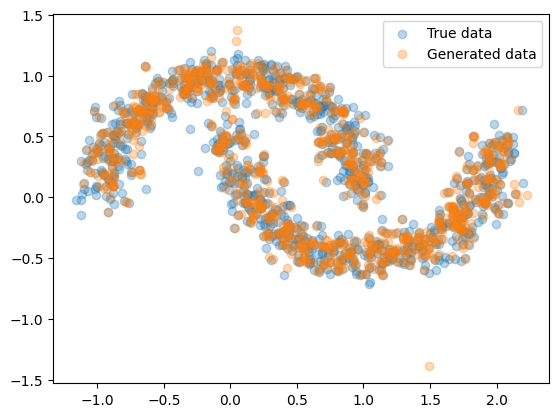

In [15]:
plt.scatter(X_true[:, 0], X_true[:, 1], alpha=0.3, label="True data")
plt.scatter(solution[:, 0], solution[:, 1], alpha=0.3, label="Generated data")
plt.legend()


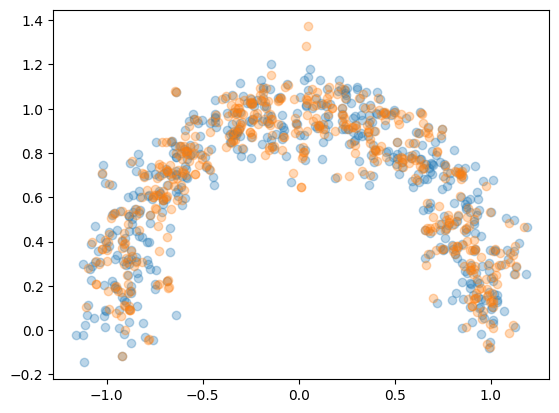

In [16]:
# plot by condition

plt.scatter(X_true[condition_true[:, 0] == 0, 0], X_true[condition_true[:, 0] == 0, 1], alpha=0.3, label="True data, condition 0")

plt.scatter(solution[conditions[:, 0] == 0, 0], solution[conditions[:, 0] == 0, 1], alpha=0.3, label="Generated data, condition 0")


We just generated fake tabular data! Lets now compare the two dataset (real vs fake).

In [17]:
Xy_true = X_true
my_data = solution

df = pd.read_csv('../data/paired_data_cuts.csv')[-100_000:]
# columns = ['fd_numu_score', 'fd_nue_score', 'fd_numu_nu_E', 'fd_numu_had_E', 'fd_nue_nu_E', 'fd_nue_had_E']
# df = df[columns]
# Xy_true = df.values

In [19]:
df

,eventID,cafTree_event,isFHC,isCC,nuPDG,NuMomX,NuMomY,NuMomZ,Ev,mode,...,fd_numu_lep_E,fd_numu_reco_method,fd_numu_longest_track_contained,fd_numu_longest_track_mom_method,fd_nue_nu_E,fd_nue_had_E,fd_nue_lep_E,fd_nue_reco_method,run_id,unique_id
61594,146,146,1,1,14,-0.020856,-0.585507,5.858920,5.888140,4,...,3.406672,1,0,0,6.793968,6.727006,0.066962,2,1000550,1000550_146
61595,150,150,1,1,14,0.019916,-0.538711,5.349063,5.376159,3,...,3.390209,1,0,0,5.192340,4.718299,0.474041,2,1000550,1000550_150
61596,159,159,1,1,14,0.006023,-0.279886,2.676746,2.691346,10,...,1.802486,1,1,1,2.883137,0.000000,0.010000,3,1000550,1000550_159
61597,168,168,1,1,-14,0.009262,-0.531327,5.284072,5.310726,1,...,3.956350,1,0,0,1.849749,0.000000,0.010000,3,1000550,1000550_168
61598,171,171,1,1,14,-0.013423,-1.651473,16.141060,16.225332,3,...,9.402841,1,0,0,11.476759,11.061234,0.415526,2,1000550,1000550_171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161589,272,272,1,1,14,0.017189,-0.254126,2.552480,2.565157,4,...,2.213495,1,0,0,1.715421,0.000000,0.010000,3,1006998,1006998_272
161590,277,277,1,1,14,0.006965,-0.310896,3.125285,3.140718,3,...,0.915975,1,1,1,3.179428,3.144960,0.034468,2,1006998,1006998_277
161591,282,282,1,1,14,-0.006713,-0.260275,2.633865,2.646702,3,...,0.498951,1,1,1,1.447122,0.000000,0.010000,3,1006998,1006998_282
161592,291,291,1,1,14,-0.024804,-0.545273,5.344900,5.372698,3,...,1.612508,1,1,1,7.148912,6.623689,0.525224,2,1006998,1006998_291


In [ ]:
Xy_true.shape, my_data.shape

((100000, 6), (1000, 2))

In [ ]:
# Real data
bins = 25
bin_range = (-0.0, 25.0)
common_params = dict(bins=bins, range=bin_range, alpha=0.5, density=True)
dim = 5
plt.hist(my_data[:, dim], **common_params, label="Generated");
plt.hist(Xy_true[:, dim], **common_params, label="True");
plt.title(f"fd , max_fake={np.max(my_data[:, dim]):.2f}, min_fake={np.min(my_data[:, dim]):.2f}")
plt.legend()

IndexError: index 5 is out of bounds for axis 1 with size 2

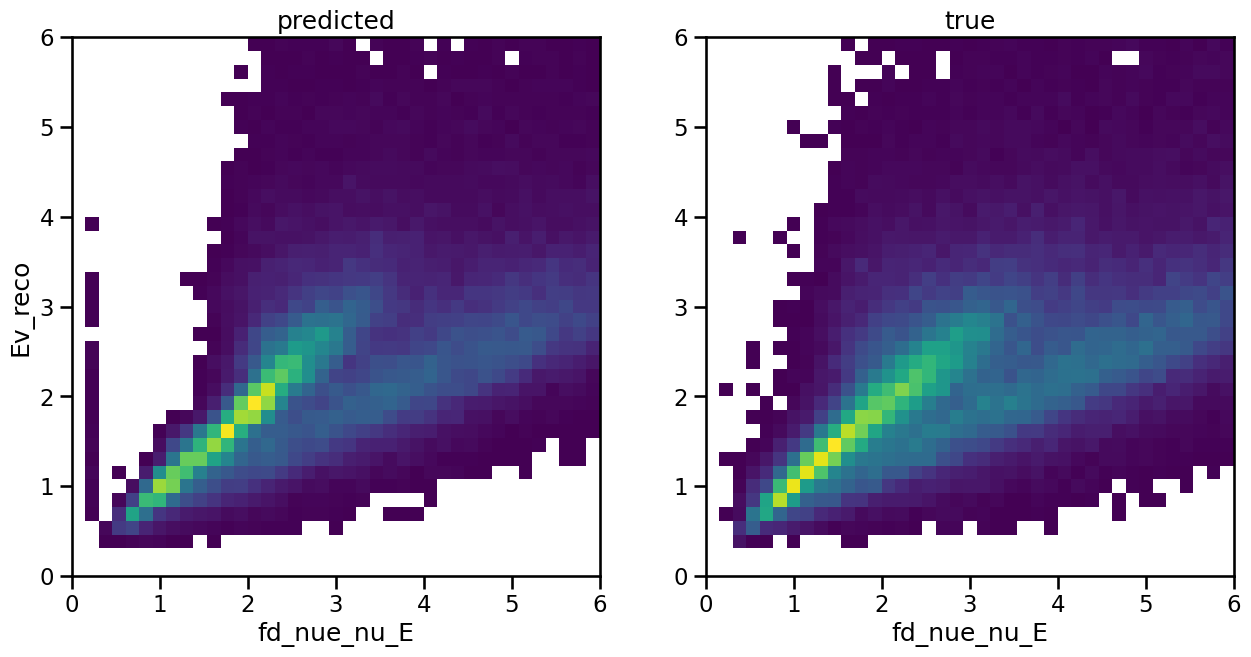

In [ ]:
import seaborn as sns
sns.set_context("talk")
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# join condition and prediction
pred = pd.DataFrame(my_data, columns=train_cols)
true = pd.DataFrame(Xy_true, columns=train_cols)

pred_cond = pd.DataFrame(conditions, columns=cond_cols)
true_cond = pd.DataFrame(conditions, columns=cond_cols)

pred = pd.concat([pred, pred_cond], axis=1)
true = pd.concat([true, true_cond], axis=1)

y_col = 'Ev_reco' #'eRecoP', 'eRecoN', 'eRecoPip', 'eRecoPim', 'eRecoPi0', 'eRecoOther', 'Ev_reco', 'Elep_reco', 'theta_reco'            
x_col = 'fd_nue_nu_E' 
by_name = lambda col, df: df[col].values
x = by_name(x_col, pred)
y = by_name(y_col, pred)
bins_y = np.linspace(0, 6, 40)
bins_x = np.linspace(0, 6, 40)
ax[0].hist2d(x, y, bins=(bins_x, bins_y), cmin=2)
ax[0].set_xlabel(x_col)
ax[0].set_ylabel(y_col)
ax[0].set_title('predicted')

x = by_name(x_col, true)
y = by_name(y_col, true)
ax[1].hist2d(x, y, bins=(bins_x, bins_y), cmin=2)
ax[1].set_xlabel(x_col)
ax[1].set_title('true');

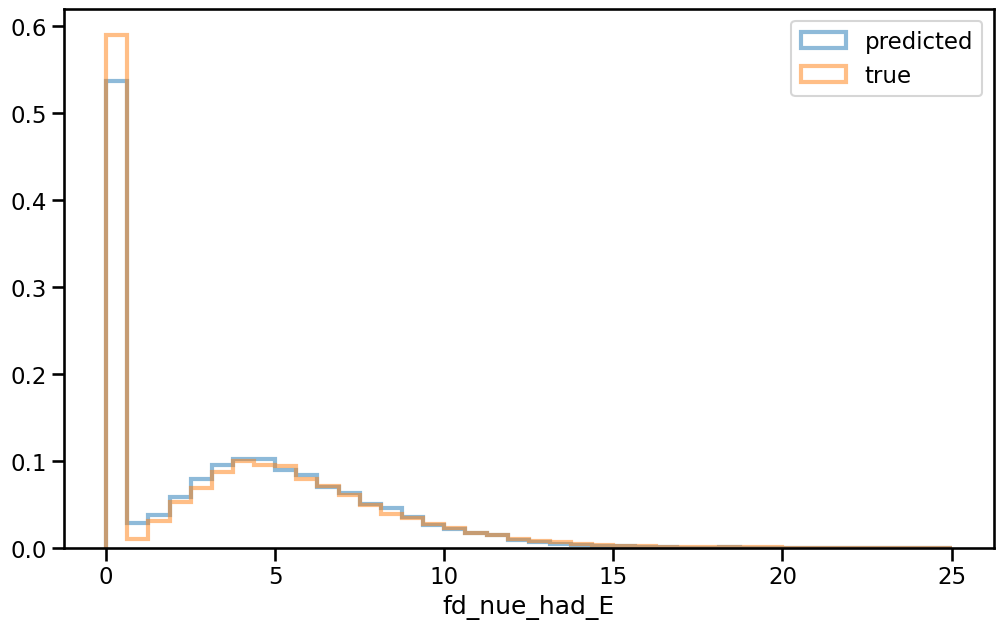

In [ ]:
# plot in 1d    
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
bin_range = (0, 25)
bins = 40
x_col = 'fd_nue_had_E'
x = by_name(x_col, pred)
true_x = by_name(x_col, true)

common_params = dict(bins=bins, range=bin_range, alpha=0.5, density=True, histtype='step', lw=3)
ax.hist(x, **common_params, label='predicted');
ax.hist(true_x, **common_params, label='true');
ax.set_xlabel(x_col)
plt.legend()

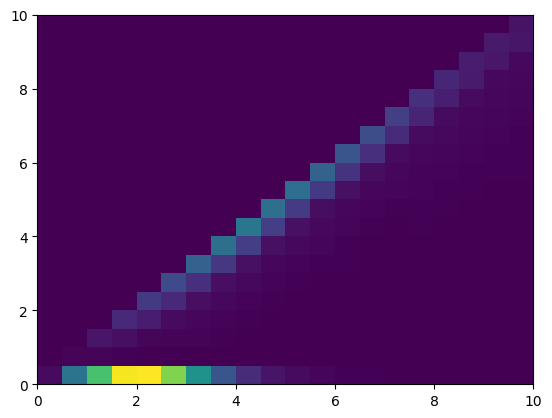

In [ ]:
plt.hist2d(Xy_true[:, dim], Xy_true[:, dim+1], bins=20, range=[bin_range, bin_range]);

In [ ]:
Xy_true

array([[9.8420376e-01, 1.7055960e-04, 5.9177570e+00, 1.1393038e+00,
        7.6271324e+00, 7.5908475e+00],
       [8.9542305e-01, 1.7431633e-04, 1.2205144e+01, 4.7268925e+00,
        1.0884376e+01, 9.0782380e+00],
       [9.6371424e-01, 3.3579842e-04, 1.0712364e+01, 1.9162247e+00,
        2.5742686e+00, 0.0000000e+00],
       ...,
       [9.9410490e-01, 3.2983076e-05, 7.2290335e+00, 2.5459716e+00,
        7.6612310e+00, 7.1835256e+00],
       [9.8850760e-01, 1.3113768e-04, 1.0283180e+01, 6.7141810e+00,
        1.4481752e+01, 1.2220632e+01],
       [9.8315597e-01, 1.3809540e-05, 3.3082333e+00, 1.4744428e+00,
        4.9997840e+00, 4.9726610e+00]])